In [ ]:
import Pkg
Pkg.add("Revise")
Pkg.add("IonSim")
Pkg.add("QuantumOptics")
Pkg.add("StochasticDiffEq")
Pkg.add("DSP")
using PyPlot
using Revise
using IonSim
using QuantumOptics: timeevolution, stochastic, Basis

    Updating registry at `C:\Users\jewoo\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.11\Manifest.toml`


In [ ]:
Pkg.add("ProgressMeter")
using Distributions # You'll need to add this package!
using ProgressMeter # For a nice progress bar

   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.11\Manifest.toml`


In [ ]:
C = Ca40([("S1/2", -1/2, "g"),("D5/2", -1/2, "e")])
# Create aliases for the qubit states for easier access
#set_sublevel_alias!(C, Dict("g" => ("S1/2", -1/2), "e" => ("D5/2", -1/2)))

# Define the trap configuration. We'll model a single ion in a linear chain
# with a 1 MHz axial motional frequency.
chain = LinearChain(
    ions=[C],
    comfrequencies=(x=3e6, y=3e6, z=1e6),   
    selectedmodes=(;z=[1]) # We only consider the axial mode of motion
)

# Define the laser that will drive the transition
L = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T = Chamber(
    iontrap=chain,
    B=0.37e-3,              # Magnetic field in Tesla
    #δB = 0.1,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L]
)

polarization!(L, (x̂ - ẑ)/√2)
wavevector!(L, (x̂ + ẑ)/√2);
wavelength_from_transition!(L, C, ("g", "e"), T)
intensity_from_pitime!(L, 4e-6, C, ("g", "e"), T);

ion = ions(T)[1]

ψ0_ion_1 = ion["g"]
ψ0_ion_2 = ion[("S1/2", -1/2)]
ψ0_ion_3 = ionstate(ion, "g")

print(ψ0_ion_1)
mode = IonSim.modes(T)[1]

ψ0_mode_1 = mode[0]
ψ0_mode_2 = fockstate(mode, 0)
ψ0_mode_3 = groundstate(mode)

print(ψ0_mode_1)
ψ₀ = ion["g"] ⊗ mode[0];
print(L)

Ket(dim=2)
  basis: ⁴⁰Ca
 1.0 + 0.0im
 0.0 + 0.0imKet(dim=11)
  basis: VibrationalMode(ν=1.0e6, axis=ẑ, N=10)
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0imλ: 7.291469963176486e-7 m
Δ: 0 Hz
̂ϵ: (x=0.7071067811865475, y=0.0, z=-0.7071067811865475)
k̂: (x=0.7071067811865475, y=0.0, z=0.7071067811865475)
I(t=0): 1.030939867952202e6 W/m²
ϕ(t=0): 0.0 ⋅ 2π


In [ ]:
function pulse(T:: Chamber , tspan, pitime, del_intensity)
    # Define the laser that will drive the transition
    L = T.lasers[1]

    # Combine all components into a single Trap object, which represents the full experiment
    # This is the main object that holds the entire state of our physical system.
    
    pi2_time = pitime/2

    res_intensity = intensity_from_pitime(L, pi2_time, T.iontrap.ions[1], ("g", "e"), T)
    actual_intensity = res_intensity + del_intensity

    intensity!(L, (actual_intensity))


    h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf);
    return h
end


function experiment(T::Chamber, wait_time, del_intensity)
    pitime = 4e-6
    tspan = 0: 0.1: (wait_time)

    h = pulse(T, tspan, pitime, del_intensity)
    return h
end

# phase!(L, phase_funtion)
# h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf);

experiment (generic function with 1 method)

In [ ]:
function detuning_intensity1(L::Laser, del_intensity, cnt, t_wait)
    L1 = Laser()

    T1 = Chamber(
        iontrap=chain,
        B=0.37e-3,              # Magnetic field in Tesla
        #δB = 0.1,
        Bhat=ẑ,              # Magnetic field direction
        lasers=[L1]
    )
    polarization!(L1, (x̂ - ẑ)/√2)
    wavevector!(L1, (x̂ + ẑ)/√2);
    wavelength_from_transition!(L1, C, ("g", "e"), T1)
    h1 = experiment(T1, t_wait, del_intensity)
    tspan = 0:0.1:t_wait
    x, y = timeevolution.schroedinger_dynamic(tspan, ψ₀, h1)
    excited_pop1 = expect(ionprojector(T1, "e"), y)
    if(t_wait == 1)
    plot(x, real.(excited_pop1))
    println(real.(excited_pop1[end]))
    println(x)
    end
    return x, real.(excited_pop1[end])

end

detuning_intensity1 (generic function with 1 method)

0.5405659189687501
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.5405659189687501
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.5380934728685998
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
1.0786593918373497
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.6216235096065291
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
1.7002829014438787
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.5246450360115256
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
2.224927937455404
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.6417645817566349
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
2.866692519212039
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.5319544913010932
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
3.398647010513132
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.5429796735618585
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
3.9416266840749907
[0.0, 0.1

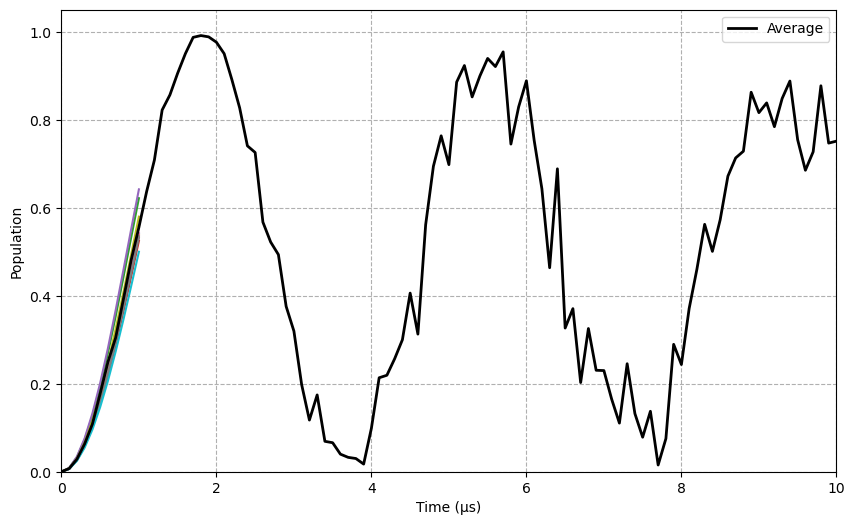

In [ ]:

figure(figsize=(10, 6))
I_rms_1 = 10
noise_distribution_1 = Normal(0, I_rms_1)
tout, ind = detuning_intensity1(L, 10*1e6, 1, 10)
# println(tout)
# println( ind)
sumB=0.0
ind = []
push!(ind, 0)
for j in 0.1:0.1:10
    sumB=0.0
    for i in 1:1:10
        δB_shot = rand(noise_distribution_1)
        tout1, indi = detuning_intensity1(L, abs(δB_shot*1e5), i, j)
        sumB= sumB + (indi)
        if(j == 1)
        println(sumB)
        println(tout1)
    end
    end
   
    push!(ind, sumB/10)
    
end
println(ind)
plot(tout, ind , label="Average", color = "black", linewidth=2)

xlim(0, 10)
xlabel("Time (μs)")
ylabel("Population")
ylim(0, 1.05)
grid(true, linestyle="--")
legend()
show()
display(gcf())

In [60]:
function detuning_intensity2(L::Laser, del_intensity, cnt, t_wait)
    L1 = Laser()

    T1 = Chamber(
        iontrap=chain,
        B=0.37e-3,              # Magnetic field in Tesla
        #δB = 0.1,
        Bhat=ẑ,              # Magnetic field direction
        lasers=[L1]
    )
    polarization!(L1, (x̂ - ẑ)/√2)
    wavevector!(L1, (x̂ + ẑ)/√2);
    wavelength_from_transition!(L1, C, ("g", "e"), T1)
    h1 = experiment(T1, t_wait, del_intensity)
    tspan = 0:0.1:t_wait
    x, y = timeevolution.schroedinger_dynamic(tspan, ψ₀, h1)
    excited_pop1 = expect(ionprojector(T1, "e"), y)
    
    return x[end], real.(excited_pop1[end])

end

detuning_intensity2 (generic function with 1 method)

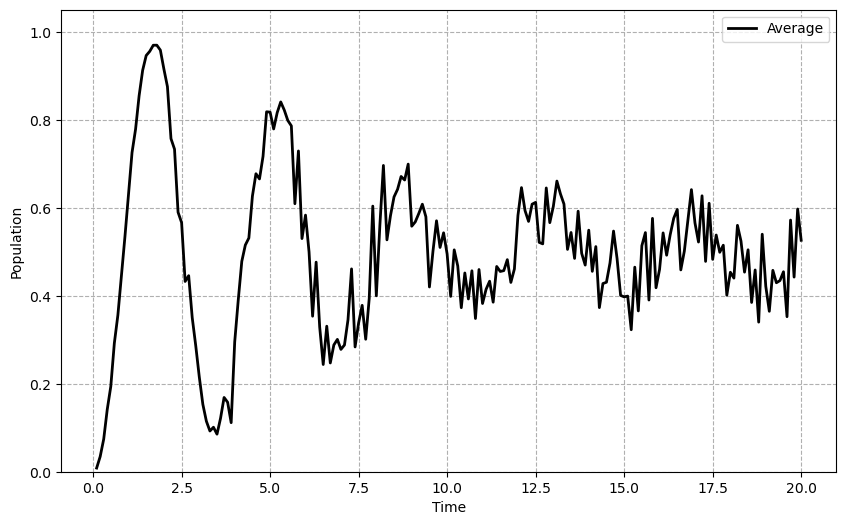

Any[0.008346673466150194, 0.03438807945048338, 0.07411624335340543, 0.1415916978848414, 0.19384135024109164, 0.2919985085329588, 0.3558128167536149, 0.44440047138104455, 0.5345957655828447, 0.6308731020110766, 0.7254162105248095, 0.7785050850525508, 0.854469731222285, 0.9123657817848517, 0.9459234975350247, 0.9554217285833976, 0.9692864421017249, 0.9693733490292714, 0.9581961130430238, 0.9150791181613823, 0.8751660438790926, 0.756973655535971, 0.7330738224595181, 0.5897525406807601, 0.5661938686918428, 0.43244293433674613, 0.44550604621004336, 0.35024864651003873, 0.28600060625537743, 0.21512332319776498, 0.15322625353468827, 0.11477001260128387, 0.09252415438869041, 0.1011207744544514, 0.08533117028225058, 0.12156911581734536, 0.16876822406292272, 0.15786351294092266, 0.1114682472627791, 0.2950851599963127, 0.3901192260883706, 0.47798997307641905, 0.515138523028312, 0.5311905271447637, 0.6263228845047037, 0.6772757274516348, 0.665380278545914, 0.716760143923727, 0.8180598343555329, 0.

In [61]:

figure(figsize=(10, 6))
I_rms_1 = 2e6
noise_distribution_1 = Normal(0, I_rms_1)
sumB=0.0
tout2 = []
ind = []
for j in 0.1:0.1:20
    sumB=0.0
    x=0
    for i in 1:1:30
        δB_shot = rand(noise_distribution_1)
        x, indi = detuning_intensity2(L, abs(δB_shot), i, j)
        sumB= sumB + (indi)
    end
    push!(tout2, x)
    push!(ind, sumB/30)
end
println(ind)
plot(tout2, ind , label="Average", color = "black", linewidth=2)

xlabel("Time")
ylabel("Population")
ylim(0, 1.05)
grid(true, linestyle="--")
legend()
show()
display(gcf())

println(L)

Any[0.007080345462655752, 0.02796226970914823, 0.0651324534905659, 0.1105091879934418, 0.1739937765962149, 0.249956689131652, 0.31866146782933374, 0.3905950228073744, 0.47494195173685383, 0.5754335786050423, 0.6695456458698775, 0.7308259513534038, 0.7973409606359573, 0.8711934720819077, 0.9183154971506784, 0.9460517538651879, 0.973859198211158, 0.9898430240020841, 0.9861647692433879, 0.9763213951165282, 0.9502913603233721, 0.8967170725891626, 0.8294460676121909, 0.7414785071574131, 0.6868331430907884, 0.6162715698301864, 0.552160797737329, 0.5168548696461186, 0.3893748113532382, 0.31499419329653006, 0.2639722598989458, 0.16907588979699317, 0.13147829275164455, 0.06368377631186957, 0.058366420720343405, 0.045507767328524865, 0.02752420609314477, 0.047844495646747025, 0.06247992201460032, 0.11423293380566615, 0.1597306769177403, 0.19398768341758166, 0.2627934685888826, 0.27885576097769144, 0.37447478149736935, 0.4329842629340382, 0.5556793441167867, 0.6573058124811352, 0.6751997355911035

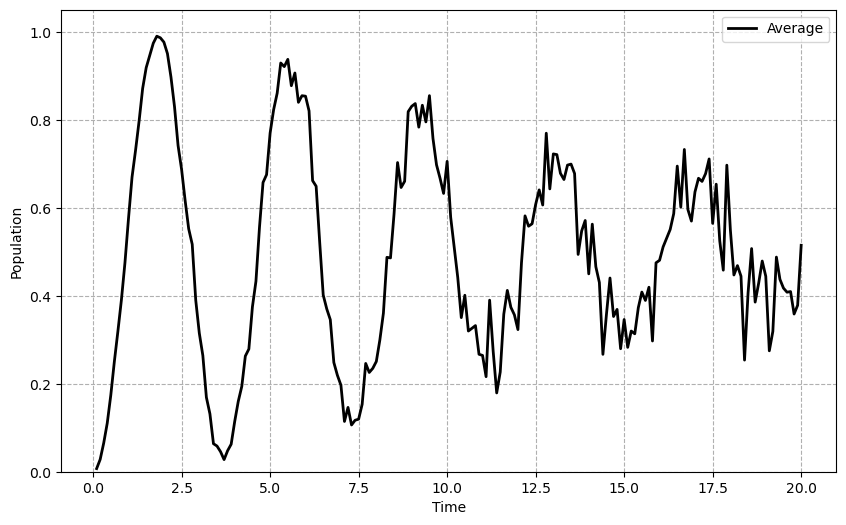

In [63]:

figure(figsize=(10, 6))
I_rms_1 = 1e6
noise_distribution_1 = Normal(0, I_rms_1)
sumB=0.0
tout2 = []
ind = []
for j in 0.1:0.1:20
    sumB=0.0
    x=0
    for i in 1:1:30
        δB_shot = rand(noise_distribution_1)
        x, indi = detuning_intensity2(L, abs(δB_shot), i, j)
        sumB= sumB + (indi)
    end
    push!(tout2, x)
    push!(ind, sumB/30)
end
println(ind)
plot(tout2, ind , label="Average", color = "black", linewidth=2)

xlabel("Time")
ylabel("Population")
ylim(0, 1.05)
grid(true, linestyle="--")
legend()
show()
display(gcf())

println(L)

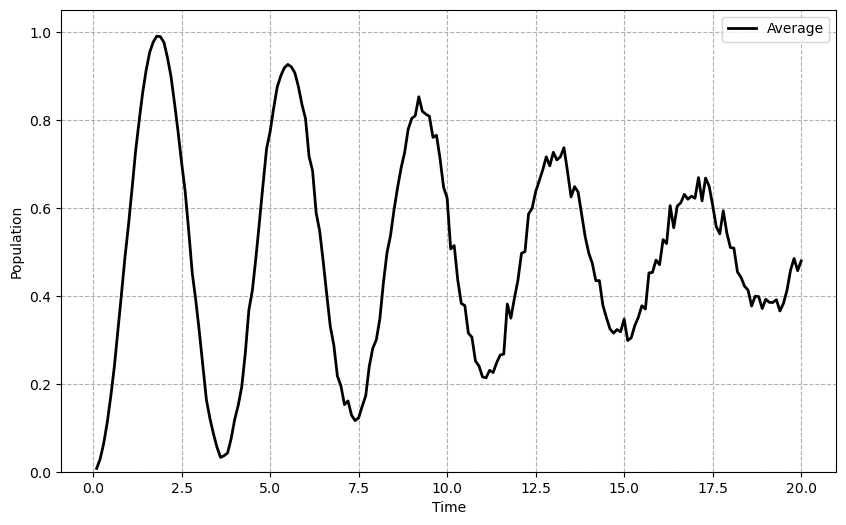

Any[0.0074011789943296755, 0.029106968773251453, 0.06454192997385032, 0.11201506463115089, 0.1713580795690132, 0.23858274659751835, 0.32056900623045, 0.4022775436793024, 0.4871571753319287, 0.5607359332970894, 0.6427235210658935, 0.7280976822093463, 0.7968696665744259, 0.8612567086078168, 0.9131242017630251, 0.9535600240077204, 0.976765731435089, 0.9899681245338613, 0.9887775433692305, 0.9759080331096709, 0.9416438107642735, 0.8984378689999499, 0.8379095761542261, 0.7728295256366772, 0.7025044164648517, 0.6376983115816306, 0.5481937172400928, 0.45221380410353423, 0.390151037948317, 0.31872714199740837, 0.24032583102158514, 0.1637709550376003, 0.12107479565600902, 0.08607381018352163, 0.055518115172578424, 0.03252286059764424, 0.036391863924167656, 0.04269981778881179, 0.0753760011071995, 0.11883969085743223, 0.15099452316973971, 0.1936547605712949, 0.27001283242529334, 0.36737719408964287, 0.41262775455681727, 0.4873142314347902, 0.5685932357908757, 0.6530608423389629, 0.73388056896084

In [67]:

figure(figsize=(10, 6))
I_rms_1 = 1e6
noise_distribution_1 = Normal(0, I_rms_1)
sumB=0.0
tout2 = []
ind = []
for j in 0.1:0.1:20
    sumB=0.0
    x=0
    for i in 1:1:200
        δB_shot = rand(noise_distribution_1)
        x, indi = detuning_intensity2(L, abs(δB_shot), i, j)
        sumB= sumB + (indi)
    end
    push!(tout2, x)
    push!(ind, sumB/200)
end
println(ind)
plot(tout2, ind , label="Average", color = "black", linewidth=2)

xlabel("Time")
ylabel("Population")
ylim(0, 1.05)
grid(true, linestyle="--")
legend()
show()
display(gcf())

println(L)